Download weights, img_proc.py, model360.py here!

URL: https://drive.google.com/drive/folders/1bhXOh2PsH1Sx4LYIMv4C_1iKqz-e-lfL?usp=sharing

In [ ]:
!pip install timm
!pip install albumentations==0.4.6
!pip install resnest
!pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=05c74798c1174595b8d55bd359983f85016f179f6b56360a5edfeb2018978b04
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e4bb71328c1d289fd7b77b18f04d8e7c9c710bae0e93021515d4c0668e7768ca
  Stored in 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/APS360/Project/img_proc.py /content
!cp /content/drive/MyDrive/APS360/Project/model360.py /content

In [ ]:
import kagglehub
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import time
from collections import defaultdict
import timm
import seaborn as sns
from itertools import combinations


from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score,classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from skimage import io, img_as_float, img_as_ubyte

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms, models
from torchvision.transforms import functional as Func
from torch.cuda.amp import GradScaler, autocast

from img_proc import get_image_path, get_image_path_bcn, shades_of_gray_skimage, remove_border, process_image, get_image, augment_image
from model360 import *


In [ ]:
device = torch.device('cuda:0')


# Loading Data

In [ ]:
#HAM10000
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:23<00:00, 239MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
#BCN20000
path = kagglehub.dataset_download("pasutchien/bcn20000")

print("Path to dataset files:", path)

100%|██████████| 9.04G/9.04G [01:09<00:00, 139MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pasutchien/bcn20000/versions/1


In [ ]:
df_meta_bcn = pd.read_csv('/root/.cache/kagglehub/datasets/pasutchien/bcn20000/versions/1/bcn_20k_train.csv')
df_meta_bcn.head(5)

,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


In [ ]:
df_meta = pd.read_csv('/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv')
df_meta.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
len(df_meta)

10015

In [ ]:
len(df_meta_bcn)

12413

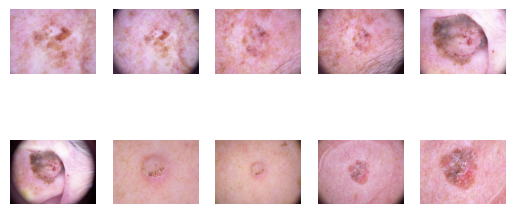

In [ ]:
for index, row in df_meta.iterrows():
  img_path = get_image_path(row["image_id"])
  image = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert BGR to RGB
  plt.subplot(3, 5, index+1)
  plt.axis('off')
  plt.imshow(image)

  if index == 9:
    break


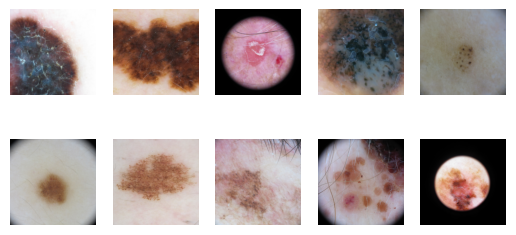

In [ ]:
for index, row in df_meta_bcn.iterrows():
  img_path = get_image_path_bcn(row["bcn_filename"])
  image = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert BGR to RGB
  plt.subplot(3, 5, index+1)
  plt.axis('off')
  plt.imshow(image)

  if index == 9:
    break

## Data Analysis

**NULL/UNKNOWN value handling**

In [ ]:
#Null Value Handling
df_meta.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [ ]:
df_meta_bcn.isna().sum()

,0
bcn_filename,0
age_approx,74
anatom_site_general,173
diagnosis,0
lesion_id,0
capture_date,0
sex,74
split,0


In [ ]:
#Unknown values Handling
columns = ["age_approx", "anatom_site_general", "diagnosis", "capture_date", "sex"]
for col in columns:
    print(f"Unique values in '{col}': {df_meta_bcn[col].unique()}")
#Seems like for BCN, unknown values are only represented as na

Unique values in 'age_approx': [55. 50. 85. 60. 30. 20. 40. 75. 80. 70. 35. 65. 15. 45. nan 10. 25.  5.
  0.]
Unique values in 'anatom_site_general': ['anterior torso' 'head/neck' 'upper extremity' 'lower extremity'
 'oral/genital' 'palms/soles' nan]
Unique values in 'diagnosis': ['MEL' 'SCC' 'NV' 'BCC' 'BKL' 'AK' 'DF' 'VASC']
Unique values in 'capture_date': ['2012-05-16' '2015-07-09' '2015-11-23' ... '2013-04-19' '2011-07-11'
 '2011-07-22']
Unique values in 'sex': ['male' 'female' nan]


In [ ]:
#Unknown Value Handling
unknown_counts = df_meta.apply(lambda x: (x == 'unknown').sum())

print(unknown_counts)

lesion_id         0
image_id          0
dx                0
dx_type           0
age               0
sex              57
localization    234
dtype: int64


********



**Duplicates Handling**

In [ ]:
#Checking for duplicates
duplicates = df_meta[df_meta[['lesion_id','dx','dx_type','age','sex','localization']].duplicated()].index
lesion_duplicates = df_meta[df_meta['lesion_id'].duplicated()].index
set_1 = set(duplicates)
set_2 = set(lesion_duplicates)

#We want to check if we want to remove duplications in lesion_id, or duplications in all the columns
diff = set_2 - set_1
print(f"Indices with same lesion_id but different values in other columns: {diff}")
df_meta.iloc[list(diff)[0]]

Indices with same lesion_id but different values in other columns: {2008, 2014}


,2008
lesion_id,HAM_0001726
image_id,ISIC_0024700
dx,mel
dx_type,histo
age,35.0
sex,female
localization,trunk


In [ ]:
#Same lesion_id but different values in other columns
dup = df_meta[df_meta['lesion_id'] == "HAM_0001726"]
dup

,lesion_id,image_id,dx,dx_type,age,sex,localization
1247,HAM_0001726,ISIC_0029281,mel,histo,35.0,female,back
1248,HAM_0001726,ISIC_0024367,mel,histo,35.0,female,back
2008,HAM_0001726,ISIC_0024700,mel,histo,35.0,female,trunk


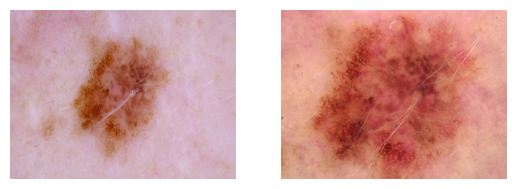

In [ ]:
img_path = get_image_path("ISIC_0029281")
image = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

img_path = get_image_path("ISIC_0024700")
image2 = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

plt.subplot(1, 2, 1)#
plt.axis('off')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image2)

There are some datas which have the same lesion_id, but different image & metadata; so, we will consider them as different data points and remove datas which has duplicated values in all columns

In [ ]:
#Duplication Test
def compare_duplicates(col1,col2, df):
    #Given duplicates from col1 is subset of duplicates from col2
    small_duplicates = df[df[col1].duplicated()].index
    large_duplicates = df[df[col2].duplicated()].index
    set_1 = set(small_duplicates)
    set_2 = set(large_duplicates)

    diff = set_2 - set_1
    if len(diff) == 0:
        print(f"duplicates from {col1} = duplicates from {col2}")
    else:
        print(f"duplicates from {col1} is a subset of duplicates from {col2}")

col1 = ["age_approx", "anatom_site_general", "diagnosis", "capture_date", "sex", "lesion_id"]
col2 = "lesion_id"
compare_duplicates(col1, col2, df_meta_bcn)



duplicates from ['age_approx', 'anatom_site_general', 'diagnosis', 'capture_date', 'sex', 'lesion_id'] is a subset of duplicates from lesion_id


In [ ]:
#We conduct a different test from HAM10000 considering there are lots of duplicates with same lesion_id but different values in other columns.
#Therefore, we want a deeper understanding of the duplicates and remove the right amount of data.
col1 = ["anatom_site_general", "lesion_id","diagnosis", "sex"] #same lesion = same area, same person, same diagnosis
compare_duplicates(col1,"lesion_id", df_meta_bcn)


duplicates from ['anatom_site_general', 'lesion_id', 'diagnosis', 'sex'] = duplicates from lesion_id


This suggests that duplicates in lesion_id are pictures of the same lesions

In [ ]:
col1 = ["age_approx", "anatom_site_general", "lesion_id","diagnosis", "capture_date", "sex"]
col2 = ['lesion_id','capture_date']
compare_duplicates(col1,col2, df_meta_bcn)


duplicates from ['age_approx', 'anatom_site_general', 'lesion_id', 'diagnosis', 'capture_date', 'sex'] = duplicates from ['lesion_id', 'capture_date']


This suggests that duplications from all the columns are duplications from lesion_id and capture_date. From this and the fact that duplications in lesion_id are picture of the same lesions, same lesions can be captured at different time.

Therefore, Duplicates from lesion_id are pictures of the same lesion which can be captured at the same or distinct time point.

---



**Data Combining**

In [ ]:
columns = ["age_approx", "anatom_site_general", "diagnosis", "sex"]
for col in columns:
    print(f"Unique values in '{col}': {df_meta_bcn[col].unique()}")

Unique values in 'age_approx': [55. 50. 85. 60. 30. 20. 40. 75. 80. 70. 35. 65. 15. 45. nan 10. 25.  5.
  0.]
Unique values in 'anatom_site_general': ['anterior torso' 'head/neck' 'upper extremity' 'lower extremity'
 'oral/genital' 'palms/soles' nan]
Unique values in 'diagnosis': ['MEL' 'SCC' 'NV' 'BCC' 'BKL' 'AK' 'DF' 'VASC']
Unique values in 'sex': ['male' 'female' nan]


In [ ]:
columns = ["age", "localization", "dx","sex"]
for col in columns:
    print(f"Unique values in '{col}': {df_meta[col].unique()}")

Unique values in 'age': [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.
 15.]
Unique values in 'localization': ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
Unique values in 'dx': ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Unique values in 'sex': ['male' 'female' 'unknown']


For Localization: we use

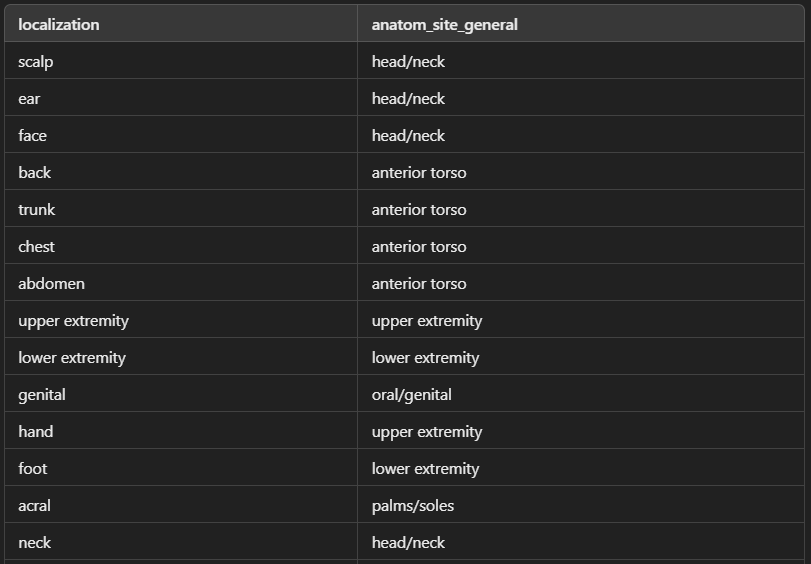

# Data Processing

In [ ]:
localization_to_anatom = {
    'scalp': 'head/neck',
    'ear': 'head/neck',
    'face': 'head/neck',
    'back': 'anterior torso',
    'trunk': 'anterior torso',
    'chest': 'anterior torso',
    'abdomen': 'anterior torso',
    'upper extremity': 'upper extremity',
    'lower extremity': 'lower extremity',
    'genital': 'oral/genital',
    'hand': 'upper extremity',
    'foot': 'lower extremity',
    'acral': 'palms/soles',
    'neck': 'head/neck',
}
diagnosis_to_dx = {
    "MEL": "mel",
    "NV": "nv",
    "BCC": "bcc",
    "BKL":"bkl",
    "AK":"akiec",
    "DF":"df",
    "VASC":"vasc"
}

**Data Cleaning**

In [ ]:
def clean_data_ham(df):
    # drop rows with unknown values for sex, localization, and age
    df = df.dropna(subset=['age'])
    df = df[(df['localization'] != 'unknown') & (df['sex'] != 'unknown')]

    #drop duplicates
    df = df.drop_duplicates(subset=df.columns.difference(['image_id']))

    # drop irrelevant metadata columns
    df = df.drop(columns=['dx_type', 'lesion_id'])

    #Age of 0 represents age from 0 to 5, we add 2.5 to get the center values
    df['age'] = df['age'] + 2.5

    #Map values in localization so that data from HAM follows the values of BCN
    df['localization'] = df['localization'].map(localization_to_anatom)

    return df

def clean_data_bcn(df):
    #From the data analysis part, BCN only contains null value and none of "unknown"
    #Drop NULL values
    df = df.dropna(subset=['age_approx','anatom_site_general', 'sex'])

    #We will consider same lesions at different timestamps to be different datapoints
    #Drop duplicates in "lesion_id" AND "capture_date"
    df = df.drop_duplicates(subset=['lesion_id', 'capture_date'])

    # drop irrelevant metadata columns
    df = df.drop(columns=['lesion_id', 'capture_date','split'])

    #Age of 0 represents age from 0 to 5, we add 2.5 to get the center values
    df['age_approx'] = df['age_approx'] + 2.5

    #Prepare data for concatenation with HAM10000
    df = df[df['diagnosis'] != 'SCC']
    df['diagnosis'] = df['diagnosis'].map(diagnosis_to_dx)

    df = df.rename(columns={'age_approx': 'age', 'anatom_site_general': 'localization', 'diagnosis':'dx','bcn_filename':'image_id'})
    return df
df_meta = clean_data_ham(df_meta)
df_meta_bcn = clean_data_bcn(df_meta_bcn)

In [ ]:
df_meta = pd.concat([df_meta, df_meta_bcn], ignore_index=True)
#Shuffle new dataset
df_meta = df_meta.sample(frac=1, random_state=0).reset_index(drop=True)

#Create one hot encoding on "sex" and "localization" columns
df_meta = pd.get_dummies(df_meta, columns=['sex','localization'], drop_first=False, dtype=int)
df_meta.head(5)

,image_id,dx,age,sex_female,sex_male,localization_anterior torso,localization_head/neck,localization_lower extremity,localization_oral/genital,localization_palms/soles,localization_upper extremity
0,ISIC_0032291,nv,62.5,0,1,1,0,0,0,0,0
1,ISIC_0033059,nv,37.5,0,1,0,0,0,0,0,1
2,BCN_0000005757.jpg,bcc,32.5,1,0,1,0,0,0,0,0
3,ISIC_0028289,nv,47.5,1,0,0,0,1,0,0,0
4,BCN_0000004353.jpg,nv,37.5,1,0,1,0,0,0,0,0


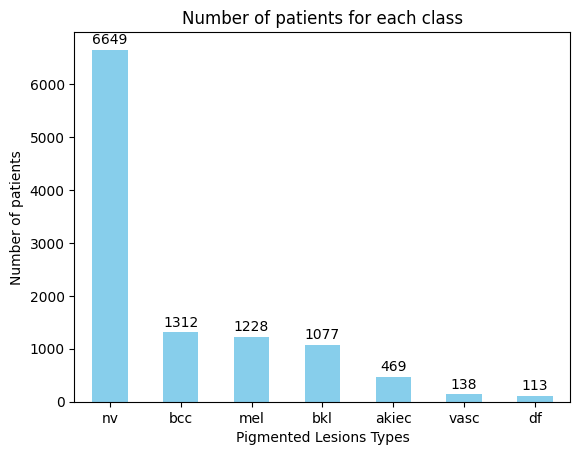

In [ ]:
#Distribution after combining datasets
dx_counts = df_meta['dx'].value_counts()
ax = dx_counts.plot(kind='bar', color='skyblue')

plt.title("Number of patients for each class")
plt.xlabel("Pigmented Lesions Types")
plt.ylabel("Number of patients")
plt.xticks(rotation=0)

for i, count in enumerate(dx_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

The graph shows a big imbalance in number of each label

In [ ]:
#Weights used in training, we do this early because we will duplicate data later and distribution will be changed.
mapping = {'nv': 0, 'akiec': 1, 'df': 2, 'vasc': 3, 'bkl':4, 'bcc':5, 'mel':6}
N = len(df_meta)
weights = {mapping[class_name]: N / count for class_name, count in dx_counts.items()}
weights

{0: 1.652278538126034,
 5: 8.373475609756097,
 6: 8.946254071661238,
 4: 10.200557103064067,
 1: 23.424307036247335,
 3: 79.6086956521739,
 2: 97.22123893805309}

In [ ]:
'''
Melanocytic nevi - Benign

Melanoma - Malignant

Benign keratosis-like lesions - Benign

Basal cell carcinoma - Malignant

Actinic keratoses - Benign

Vascular lesions - Benign

Dermatofibroma - Benign
'''
# Get count of benign conditions
benign = df_meta[df_meta['dx'].isin(['nv', 'bkl', 'akiec', 'vasc', 'df'])]['dx'].value_counts()
print("\nTotal benign cases:", benign.sum())

# Get count of malignant conditions
malignant = df_meta[df_meta['dx'].isin(['mel', 'bcc'])]['dx'].value_counts()
print("\nTotal malignant cases:", malignant.sum())



Total benign cases: 8446

Total malignant cases: 2540


Changing label to Benign and Malignant does not solve data imbalance; so, we will work with multiclass classification.




---



HAM Processing

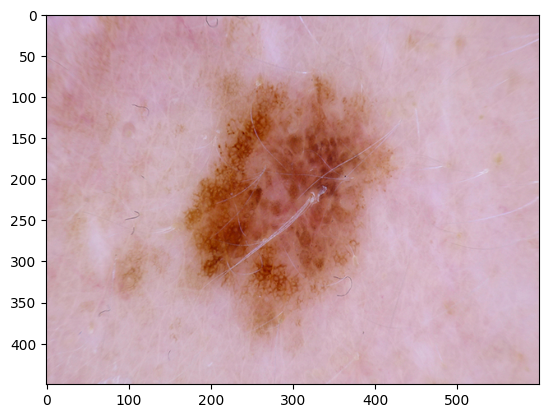

In [ ]:
path = get_image_path("ISIC_0029281")
unprocessed = cv2.imread(path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
unprocessed = cv2.cvtColor(unprocessed, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

plt.imshow(unprocessed)

Min and Max of augmented image: tensor(-0.9998) tensor(0.8326)


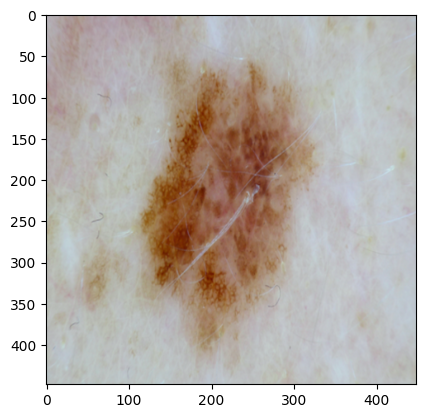

In [ ]:
sample = get_image("ISIC_0029281", True, 448, 448, True)
print("Min and Max of augmented image:", sample.min(), sample.max())

sample = np.transpose(sample, [1,2,0])
sample = sample / 2 + 0.5
plt.imshow(sample)


Min and Max of augmented image: tensor(-1.) tensor(0.9608)


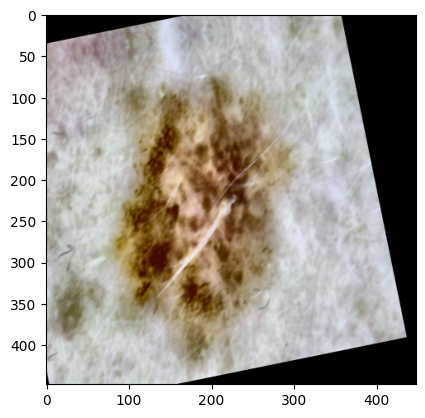

In [ ]:
augmented = augment_image((sample.numpy() * 255).astype(np.uint8),448)[0]
print("Min and Max of augmented image:", augmented.min(), augmented.max())

augmented = augmented / 2 + 0.5
plt.imshow(augmented.permute(1, 2, 0).cpu().numpy())





---
BCN Processing


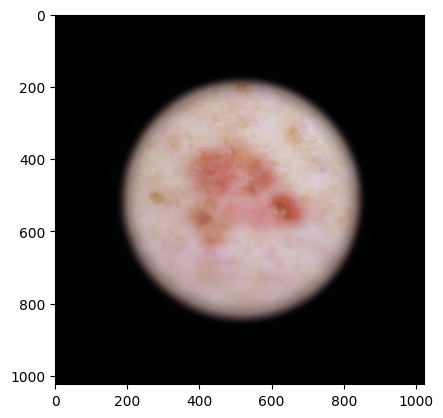

In [ ]:
path = get_image_path_bcn("BCN_0000001088.jpg")
unprocessed = cv2.imread(path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
unprocessed = cv2.cvtColor(unprocessed, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

plt.imshow(unprocessed)

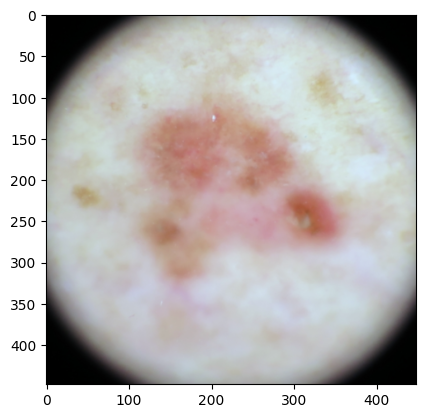

In [ ]:
#Border is removed
sample = get_image("BCN_0000001088.jpg", True, 448, 448, True)
sample = np.transpose(sample, [1,2,0])
sample = sample / 2 + 0.5
plt.imshow(sample)

**Train-Validation-Test Split**

In [ ]:
# Train-Validation-Test (0.7-0.15-0.15)
# First split for training and temp (validation + test)
train_data, temp = train_test_split(df_meta, test_size=0.3, random_state=0, stratify=df_meta['dx'])

# Second split to divide temp into validation and test
val_data, test_data= train_test_split(temp, test_size=0.5, random_state=0, stratify=temp['dx'])

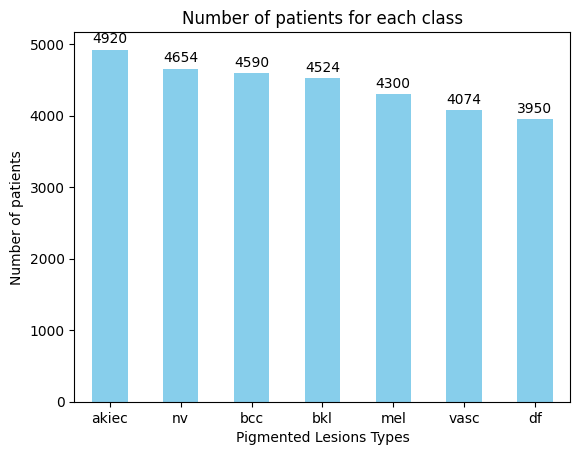

In [ ]:
#Duplicates minorities classes from train
multiplier = {"bcc":5, "mel":5 ,"bkl":6,"akiec":15,"vasc":42,"df":50}

def duplicate_minority_classes(df, multiplier):
    augmented_dfs = [df]  # Start with the original DataFrame

    for dx_class, factor in multiplier.items():
        class_rows = df[df["dx"] == dx_class]
        duplicated_rows = pd.concat([class_rows] * (factor - 1), ignore_index=True)  # Duplicate (factor - 1) times
        augmented_dfs.append(duplicated_rows)

    augmented_df = pd.concat(augmented_dfs, ignore_index=True)
    return augmented_df
train_data = duplicate_minority_classes(train_data, multiplier)

#Generating class distribution
dx_counts = train_data['dx'].value_counts()
ax = dx_counts.plot(kind='bar', color='skyblue')

plt.title("Number of patients for each class")
plt.xlabel("Pigmented Lesions Types")
plt.ylabel("Number of patients")
plt.xticks(rotation=0)

for i, count in enumerate(dx_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


In [ ]:
def separate_X_y(df):
    X = df.drop(columns=['dx'])
    y = df['dx']
    return X,y

In [ ]:
train_data = train_data.sample(frac=1).reset_index(drop=True)


X_train, y_train = separate_X_y(train_data)
X_val, y_val = separate_X_y(val_data)
X_test, y_test = separate_X_y(test_data)


# Primary Model

In [ ]:
def load_data(batch_size, width=200, height=150, with_train = True):
    def create_dataset(X,y, validation):
      #Convert labels to number
      mapping = {'nv': 0, 'akiec': 1, 'df': 2, 'vasc': 3, 'bkl':4, 'bcc':5, 'mel':6}
      y = torch.tensor((y.map(mapping)).to_numpy(),dtype=torch.float32)

      #Get images with Preprocessing, Normalization, and Augmentation (For training set) applied
      X_img = X['image_id'].apply(get_image, args=(True, width, height, validation))
      X_img = torch.tensor(np.stack(X_img.values), dtype=torch.float32)

      #Get metadata
      X_meta = torch.tensor(X.drop(columns=['image_id']).values.tolist(), dtype=torch.float32)

      #Group the three together
      dataset = TensorDataset(X_img, X_meta, y)
      return dataset

    val_data = create_dataset(X_val, y_val, True)
    test_data = create_dataset(X_test, y_test, True)

    val_indices = list(range(len(val_data)))
    test_indices = list(range(len(test_data)))

    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    if with_train == False:
        return (val_loader, test_loader)
    else:
        train_data = create_dataset(X_train, y_train, False)

        train_indices = list(range(len(train_data)))

        train_sampler = SubsetRandomSampler(train_indices)

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1, sampler=train_sampler)

        return (train_loader, val_loader, test_loader)

def inspect_loader(loader, loader_name):
    total_samples = 0
    class_counts = defaultdict(int)

    for images, metadata, labels in loader:
        batch_size = images.size(0)
        total_samples += batch_size
        for label in labels:
            actual = label.item()
            class_counts[actual] += 1

    print(f"{loader_name}:")
    print(f"  Total samples: {total_samples}")
    print(f"  Class distribution: {dict(class_counts)}")
    return total_samples, dict(class_counts)

In [ ]:
train_loader, val_loader, test_loader = load_data(64, 224, 224)


In [ ]:
#For testing purposes
val_loader, test_loader = load_data(64, 224, 224, False)

In [ ]:
def mixup_data(x, y, alpha=1.0, device='cuda'):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
def evaluateCNN(net, loader, criterion, include_meta = False, clas_report=False):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    #Collect all the labels, and predictions
    all_true = []
    all_pred = []

    with torch.no_grad():
      for i, data in enumerate(loader, 0):

          inputs, meta, labels = data
          inputs = inputs.to(device)
          meta = meta.to(device)
          labels = labels.long().to(device)

          if include_meta == False:
            outputs = net(inputs)
          else:
            outputs = net(inputs, meta)

          loss = criterion(outputs, labels)
          predicted = torch.argmax(outputs, dim=1)
          all_true.append(labels)
          all_pred.append(predicted)
          corr = predicted != labels
          total_err += int(corr.sum())
          total_loss += loss.item()
          total_epoch += len(labels)

    all_true = torch.cat(all_true)
    all_pred = torch.cat(all_pred)

    # Convert to numpy for score calculation
    all_true = all_true.cpu().numpy()
    all_pred = all_pred.cpu().numpy()

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    if clas_report:
      class_names = [name for name, idx in sorted(mapping.items(), key=lambda x: x[1])]
      print(classification_report(all_true, all_pred, target_names=class_names))
    return err, loss, f1_score(all_true,all_pred,average='weighted'),  recall_score(all_true,all_pred,average='weighted'), balanced_accuracy_score(all_true,all_pred)
def plot_training_curve(path, f1= None):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.
    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    if f1 != None:
        plt.plot(range(1,n+1), f1, label="Validation F1")
        plt.xlabel("Epoch")
        plt.ylabel("F1")
        plt.legend(loc="best")
        plt.show()


def train(net, batch_size = 64, learning_rate=0.01, num_epochs=30, width=200, height=150, include_meta = False, train_loader = None, val_loader = None):
    net.train()

    sorted_weights = {k: weights[k] for k in sorted(weights.keys())}
    w = torch.tensor(list(sorted_weights.values())).sqrt_()
    print(f"Weights Used: {w}")

    w = w.to(device)
    #Weighted Cross Entropy Loss
    criterion = nn.CrossEntropyLoss(weight=w)

    #Adam with weight decay
    optimizer = torch.optim.AdamW(
        net.parameters(),
        lr=learning_rate,
        weight_decay=2e-4,
        betas=(0.9, 0.999)
    )

    #Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=4e-4,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,
        anneal_strategy='cos'
    )
    scaler = torch.amp.GradScaler("cuda")

    #Initializing all the loss records
    #Note: We applied MixUp, so the only training metrics we should use is train_loss
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    f1 = np.zeros(num_epochs)
    train_bal_acc = np.zeros(num_epochs)
    val_bal_acc = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
      total_train_loss = 0.0
      total_train_err = 0.0
      total_epoch = 0
      all_true = []
      all_pred = []


      for i, data in enumerate(train_loader, 0):

        inputs, meta, labels = data
        inputs = inputs.to(device)
        meta = meta.to(device)
        labels = labels.long().to(device)

        if random.random() < 0.5:
            # Apply MixUp
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=1.0, device=device)

            optimizer.zero_grad()
            if include_meta == False:
                outputs = net(inputs)
            else:
                outputs = net(inputs, meta)

            # Mixup loss
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        else:
            # Normal training without MixUp
            optimizer.zero_grad()
            if include_meta == False:
                outputs = net(inputs)
            else:
                outputs = net(inputs, meta)

            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        #Gradient Clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        predicted = torch.argmax(outputs, dim=1)

        all_true.append(labels)
        all_pred.append(predicted)

        corr = predicted != labels
        total_train_err += int(corr.sum())
        total_train_loss += loss.item()
        total_epoch += len(labels)

      scheduler.step()
      all_true = torch.cat(all_true)
      all_pred = torch.cat(all_pred)

      # Convert to numpy for score calculation
      all_true = all_true.cpu().numpy()
      all_pred = all_pred.cpu().numpy()
      train_bal_acc[epoch] =  balanced_accuracy_score(all_true,all_pred)

      train_err[epoch] = float(total_train_err) / total_epoch
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_err[epoch], val_loss[epoch], f1[epoch], sensitivity, val_bal_acc[epoch] = evaluateCNN(net, val_loader, criterion, include_meta = include_meta)

      print(("Epoch {}: Average Train Loss: {}|"+
            "Balanced Validation Accuracy: {}, Validation Sensitivity: {}, Validation F1 Score: {}").format(
                epoch + 1,
                train_loss[epoch],
                val_bal_acc[epoch],
                sensitivity,
                f1[epoch]))
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    return f1, val_bal_acc


In [ ]:
def alternate_training(net, train_CNN_layers, num_swap, batch_size, learning_rate, epochs_per_swap, width, height, train_loader, val_loader):
    def train_CNN(net, train_layers, batch_size, learning_rate, epochs_per_swap, width, height, train_loader, val_loader):

        #Freeze metadata and classification layers
        for param in net.ann.parameters():
            param.requires_grad = False

        for param in net.fc.parameters():
            param.requires_grad = False

        #Train CNN and unfreeze some of the blocks
        for i, layer in enumerate(net.cnn):
            if i in train_layers:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                for param in layer.parameters():
                    param.requires_grad = False
        f1, val_bal_acc = train(net,
                                batch_size = batch_size,
                                learning_rate=learning_rate,
                                num_epochs = epochs_per_swap,
                                width=width, height = height,
                                include_meta = True,
                                train_loader = train_loader, val_loader = val_loader)
        return val_bal_acc
    def train_meta_fc(net, batch_size, learning_rate, epochs_per_swap, width, height, train_loader, val_loader):
        #Unfreeze metadata and classification layers
        for param in net.ann.parameters():
            param.requires_grad = True

        for param in net.fc.parameters():
            param.requires_grad = True
        #Freeze CNN layers
        for param in net.cnn.parameters():
            param.requires_grad = False
        f1, val_bal_acc = train(net,
                                batch_size = batch_size,
                                learning_rate=learning_rate,
                                num_epochs = epochs_per_swap,
                                width=width, height = height,
                                include_meta = True,
                                train_loader = train_loader, val_loader = val_loader)
        return val_bal_acc
    for i in range(num_swap):
        if i % 2 == 0:
            print(f"Swap {i}: Training CNN...")
            validation_accuracies = train_CNN(net, train_CNN_layers, batch_size, learning_rate, epochs_per_swap, width, height, train_loader, val_loader)
            best_acc_index = np.argmax(validation_accuracies)
            print(f"Best Balanced Validation Accuracies: {validation_accuracies[best_acc_index]}, Loading Best Model")

            #Load model with best balanced validation accuracies
            model_path = get_model_name(net.name, batch_size, learning_rate, best_acc_index)
            state = torch.load(model_path)
            net.load_state_dict(state)
            print("=====================================================================================================================")

            #Save the best model from this iteration
            torch.save(net.state_dict(), f"{net.name}_Swap{i}")
        else:
            print(f"Swap {i}: Training Meta and FC")
            validation_accuracies = train_meta_fc(net, batch_size, learning_rate, epochs_per_swap, width, height, train_loader, val_loader)
            best_acc_index = np.argmax(validation_accuracies)
            print(f"Best Balanced Validation Accuracies: {validation_accuracies[best_acc_index]}, Loading Best Model")

            #Load model with best balanced validation accuracies
            model_path = get_model_name(net.name, batch_size, learning_rate, best_acc_index)
            state = torch.load(model_path)
            net.load_state_dict(state)
            print("=====================================================================================================================")

            #Save the best model from this iteration
            torch.save(net.state_dict(), f"{net.name}_Swap{i}")



In [ ]:
net = EffNetB0()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

In [ ]:
alternate_training(net, trainable_blocks[4:], 3, 64, 5e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.7724815029458902|Balanced Validation Accuracy: 0.3163937698845941, Validation Sensitivity: 0.07888349514563107, Validation F1 Score: 0.07894881100764527
Epoch 2: Average Train Loss: 1.2541726613782116|Balanced Validation Accuracy: 0.5325722636848982, Validation Sensitivity: 0.3058252427184466, Validation F1 Score: 0.34855791847677114
Epoch 3: Average Train Loss: 1.0783343439249649|Balanced Validation Accuracy: 0.5810144203999396, Validation Sensitivity: 0.470873786407767, Validation F1 Score: 0.5351733520848205
Epoch 4: Average Train Loss: 1.0060213793184338|Balanced Validation Accuracy: 0.6257175766617918, Validation Sensitivity: 0.5066747572815534, Validation F1 Score: 0.5603311758185414
Epoch 5: Average Train Loss: 0.9560060215979508|Balanced Validation Accuracy: 0.6465735235056946, Validation Sensitivity: 0.533373786407767, Validation F1 Score: 0.579

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 1: Average Train Loss: 1.289940079462897|Balanced Validation Accuracy: 0.4794848285373736, Validation Sensitivity: 0.20570388349514562, Validation F1 Score: 0.2563347383456363
Epoch 2: Average Train Loss: 1.1275493836894477|Balanced Validation Accuracy: 0.5318022498983667, Validation Sensitivity: 0.28519417475728154, Validation F1 Score: 0.3494236860683367
Epoch 3: Average Train Loss: 1.084744251757553|Balanced Validation Accuracy: 0.570981618910286, Validation Sensitivity: 0.3561893203883495, Validation F1 Score: 0.4263858348247407
Epoch 4: Average Train Loss: 1.0588061776357827|Balanced Validation Accuracy: 0.5823725623057766, Validation Sensitivity: 0.39563106796116504, Validation F1 Score: 0.4679282068873034
Epoch 5: Average Train Loss: 1.0576739156369082|Balanced Validation Accuracy: 0.596073367318213, Validation Sensitivity: 0.4162621359223301, Validation F1 Score: 0.4879952316292545
Epoch 6: Average Train Loss: 1.0498669625557575|Balanced Validation Accuracy: 0.60588698019

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 1: Average Train Loss: 1.0887974047169242|Balanced Validation Accuracy: 0.6479377112209856, Validation Sensitivity: 0.5212378640776699, Validation F1 Score: 0.5721887314551698
Epoch 2: Average Train Loss: 0.8894716975615197|Balanced Validation Accuracy: 0.6614487438713192, Validation Sensitivity: 0.6134708737864077, Validation F1 Score: 0.6543997222698082
Epoch 3: Average Train Loss: 0.8139692187923746|Balanced Validation Accuracy: 0.6395673282787426, Validation Sensitivity: 0.6116504854368932, Validation F1 Score: 0.6465597294109627
Epoch 4: Average Train Loss: 0.7984767932867266|Balanced Validation Accuracy: 0.6374599007857993, Validation Sensitivity: 0.5952669902912622, Validation F1 Score: 0.636674128527391
Epoch 5: Average Train Loss: 0.80450370827901|Balanced Validation Accuracy: 0.6480270031460451, Validation Sensitivity: 0.5976941747572816, Validation F1 Score: 0.6365285929040323
Epoch 6: Average Train Loss: 0.7299438097735041|Balanced Validation Accuracy: 0.6618478914288

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = EffNetB1()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 141MB/s]


In [ ]:
alternate_training(net, trainable_blocks[4:], 3, 64, 5e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.6903990966757547|Balanced Validation Accuracy: 0.3808014052244624, Validation Sensitivity: 0.1486650485436893, Validation F1 Score: 0.1897048719331694
Epoch 2: Average Train Loss: 1.2302482012620906|Balanced Validation Accuracy: 0.5269547539020615, Validation Sensitivity: 0.3592233009708738, Validation F1 Score: 0.4258417400319601
Epoch 3: Average Train Loss: 1.0769349962165675|Balanced Validation Accuracy: 0.5925494056994598, Validation Sensitivity: 0.4975728155339806, Validation F1 Score: 0.5571332771900387
Epoch 4: Average Train Loss: 1.010944597008302|Balanced Validation Accuracy: 0.6078634711160438, Validation Sensitivity: 0.508495145631068, Validation F1 Score: 0.5593901294484342
Epoch 5: Average Train Loss: 0.961392103273844|Balanced Validation Accuracy: 0.6094217581184053, Validation Sensitivity: 0.5078883495145631, Validation F1 Score: 0.5564438

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 1: Average Train Loss: 1.2285343721969841|Balanced Validation Accuracy: 0.5523742522052507, Validation Sensitivity: 0.38106796116504854, Validation F1 Score: 0.45993748615677904
Epoch 2: Average Train Loss: 1.0662383751770885|Balanced Validation Accuracy: 0.5839142975556817, Validation Sensitivity: 0.4429611650485437, Validation F1 Score: 0.518811719146928
Epoch 3: Average Train Loss: 1.0244138906911477|Balanced Validation Accuracy: 0.5983699944197224, Validation Sensitivity: 0.4987864077669903, Validation F1 Score: 0.5666902704682104
Epoch 4: Average Train Loss: 1.0171906299197797|Balanced Validation Accuracy: 0.609903992335967, Validation Sensitivity: 0.5115291262135923, Validation F1 Score: 0.5753514102038633
Epoch 5: Average Train Loss: 1.0064706009073356|Balanced Validation Accuracy: 0.6168205305863493, Validation Sensitivity: 0.5285194174757282, Validation F1 Score: 0.5892152649835134
Epoch 6: Average Train Loss: 0.9702471677789983|Balanced Validation Accuracy: 0.6233128180

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 2: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.0149520796598848|Balanced Validation Accuracy: 0.6353069468245262, Validation Sensitivity: 0.5770631067961165, Validation F1 Score: 0.6253649504158684
Epoch 2: Average Train Loss: 0.7471306232447477|Balanced Validation Accuracy: 0.6565985919642198, Validation Sensitivity: 0.6049757281553398, Validation F1 Score: 0.6449218694304062
Epoch 3: Average Train Loss: 0.7024377287970376|Balanced Validation Accuracy: 0.6681121473056165, Validation Sensitivity: 0.6043689320388349, Validation F1 Score: 0.6437610921667101
Epoch 4: Average Train Loss: 0.6333908234060425|Balanced Validation Accuracy: 0.6775076532232331, Validation Sensitivity: 0.6365291262135923, Validation F1 Score: 0.6720567012319365
Epoch 5: Average Train Loss: 0.5984044277022794|Balanced Validation Accuracy: 0.6838258819949479, Validation Sensitivity: 0.649878640776699, Validation F1 Score: 0.68363

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = EffNetB2()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

In [ ]:
alternate_training(net, trainable_blocks[4:], 3, 64, 5e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.7106504661520732|Balanced Validation Accuracy: 0.3585850121733449, Validation Sensitivity: 0.07342233009708737, Validation F1 Score: 0.0584378313183079
Epoch 2: Average Train Loss: 1.2141903680624422|Balanced Validation Accuracy: 0.5408694912363206, Validation Sensitivity: 0.38652912621359226, Validation F1 Score: 0.45486299193140756
Epoch 3: Average Train Loss: 1.0414622598087664|Balanced Validation Accuracy: 0.6138851812942974, Validation Sensitivity: 0.5364077669902912, Validation F1 Score: 0.5897443705229732
Epoch 4: Average Train Loss: 0.9527000588854564|Balanced Validation Accuracy: 0.5971485725741458, Validation Sensitivity: 0.5503640776699029, Validation F1 Score: 0.596766466040908
Epoch 5: Average Train Loss: 0.9084106986055669|Balanced Validation Accuracy: 0.6151061931471709, Validation Sensitivity: 0.5588592233009708, Validation F1 Score: 0.60

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 1: Training Meta and FC
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.1919906876750828|Balanced Validation Accuracy: 0.5528975795355893, Validation Sensitivity: 0.36347087378640774, Validation F1 Score: 0.4333909621411254
Epoch 2: Average Train Loss: 0.9899162350856152|Balanced Validation Accuracy: 0.5780269250765956, Validation Sensitivity: 0.4338592233009709, Validation F1 Score: 0.5022104347821137
Epoch 3: Average Train Loss: 0.9625804321053102|Balanced Validation Accuracy: 0.5930445588352862, Validation Sensitivity: 0.4811893203883495, Validation F1 Score: 0.5469392103843916
Epoch 4: Average Train Loss: 0.9421826932848114|Balanced Validation Accuracy: 0.601782062082607, Validation Sensitivity: 0.49514563106796117, Validation F1 Score: 0.5567481088535008
Epoch 5: Average Train Loss: 0.9156749343749174|Balanced Validation Accuracy: 0.6078645009007619, Validation Sensitivity: 0.5297330097087378, Validation F1 Score: 

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 2: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 0.9481417437189633|Balanced Validation Accuracy: 0.6346675105393549, Validation Sensitivity: 0.5879854368932039, Validation F1 Score: 0.6302105000548225
Epoch 2: Average Train Loss: 0.5719503481517133|Balanced Validation Accuracy: 0.6347893469410619, Validation Sensitivity: 0.6371359223300971, Validation F1 Score: 0.6718376341535024
Epoch 3: Average Train Loss: 0.5022827084416274|Balanced Validation Accuracy: 0.6314273981904324, Validation Sensitivity: 0.6456310679611651, Validation F1 Score: 0.6758850559621851
Epoch 4: Average Train Loss: 0.4832398884824103|Balanced Validation Accuracy: 0.6587785497640846, Validation Sensitivity: 0.6571601941747572, Validation F1 Score: 0.6877534433367981
Epoch 5: Average Train Loss: 0.48222659711927635|Balanced Validation Accuracy: 0.6461566960066791, Validation Sensitivity: 0.6820388349514563, Validation F1 Score: 0.706

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = EffNetB3()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

In [ ]:
alternate_training(net, trainable_blocks[4:], 3, 64, 5e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.816304150315904|Balanced Validation Accuracy: 0.27715312565105493, Validation Sensitivity: 0.03944174757281554, Validation F1 Score: 0.025579833615000387
Epoch 2: Average Train Loss: 1.2856149147466287|Balanced Validation Accuracy: 0.5442698842374034, Validation Sensitivity: 0.3179611650485437, Validation F1 Score: 0.3456792467912039
Epoch 3: Average Train Loss: 1.0857884075223785|Balanced Validation Accuracy: 0.6092844465352331, Validation Sensitivity: 0.4575242718446602, Validation F1 Score: 0.5061996667378583
Epoch 4: Average Train Loss: 0.9953030804997867|Balanced Validation Accuracy: 0.6226505314003561, Validation Sensitivity: 0.49271844660194175, Validation F1 Score: 0.5353564580707076
Epoch 5: Average Train Loss: 0.9269773294630739|Balanced Validation Accuracy: 0.6315304174044506, Validation Sensitivity: 0.5175970873786407, Validation F1 Score: 0.

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 1: Training Meta and FC
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.3463819374743196|Balanced Validation Accuracy: 0.48148630751951504, Validation Sensitivity: 0.21844660194174756, Validation F1 Score: 0.26364747590644194
Epoch 2: Average Train Loss: 1.200205230221306|Balanced Validation Accuracy: 0.499605541587126, Validation Sensitivity: 0.2712378640776699, Validation F1 Score: 0.32833790277602554
Epoch 3: Average Train Loss: 1.1539753611554804|Balanced Validation Accuracy: 0.527089827920886, Validation Sensitivity: 0.33677184466019416, Validation F1 Score: 0.40471244308720666
Epoch 4: Average Train Loss: 1.1184953330718366|Balanced Validation Accuracy: 0.54458535410764, Validation Sensitivity: 0.379247572815534, Validation F1 Score: 0.450287955436817
Epoch 5: Average Train Loss: 1.0893105327468557|Balanced Validation Accuracy: 0.5482025252120177, Validation Sensitivity: 0.39987864077669905, Validation F1 Score: 0

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 2: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.0398697473339198|Balanced Validation Accuracy: 0.6370013358649941, Validation Sensitivity: 0.5831310679611651, Validation F1 Score: 0.6293586624006214
Epoch 2: Average Train Loss: 0.6990188444858974|Balanced Validation Accuracy: 0.6694281276734705, Validation Sensitivity: 0.6547330097087378, Validation F1 Score: 0.6841957680998719
Epoch 3: Average Train Loss: 0.5807452779532093|Balanced Validation Accuracy: 0.6535638669336301, Validation Sensitivity: 0.6201456310679612, Validation F1 Score: 0.6557102546775342
Epoch 4: Average Train Loss: 0.5363659143524686|Balanced Validation Accuracy: 0.6540690913434702, Validation Sensitivity: 0.6486650485436893, Validation F1 Score: 0.6801744396476818
Epoch 5: Average Train Loss: 0.5504138179008187|Balanced Validation Accuracy: 0.6547900150246164, Validation Sensitivity: 0.6656553398058253, Validation F1 Score: 0.6963

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = ResNet18Model()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [ ]:
alternate_training(net, trainable_blocks[4:], 3, 64, 5e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.5025944205903516|Balanced Validation Accuracy: 0.5106296113253544, Validation Sensitivity: 0.30339805825242716, Validation F1 Score: 0.36170845327850504
Epoch 2: Average Train Loss: 1.0776331980203844|Balanced Validation Accuracy: 0.5579323697701555, Validation Sensitivity: 0.43264563106796117, Validation F1 Score: 0.49690084431014664
Epoch 3: Average Train Loss: 1.0145434990371625|Balanced Validation Accuracy: 0.5955162181229683, Validation Sensitivity: 0.4981796116504854, Validation F1 Score: 0.5545956781476904
Epoch 4: Average Train Loss: 0.9517950955739956|Balanced Validation Accuracy: 0.6130721341805475, Validation Sensitivity: 0.4890776699029126, Validation F1 Score: 0.5323129933561976
Epoch 5: Average Train Loss: 0.9040066351595614|Balanced Validation Accuracy: 0.6030756146978552, Validation Sensitivity: 0.5030339805825242, Validation F1 Score: 0.

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 1: Average Train Loss: 0.9548745952316167|Balanced Validation Accuracy: 0.6276246310912771, Validation Sensitivity: 0.5103155339805825, Validation F1 Score: 0.5612037808148727
Epoch 2: Average Train Loss: 0.7492274360558422|Balanced Validation Accuracy: 0.6391462068007202, Validation Sensitivity: 0.5546116504854369, Validation F1 Score: 0.6008192539689424
Epoch 3: Average Train Loss: 0.7238030745811069|Balanced Validation Accuracy: 0.6324497080028701, Validation Sensitivity: 0.558252427184466, Validation F1 Score: 0.6037638209886528
Epoch 4: Average Train Loss: 0.6841354600547516|Balanced Validation Accuracy: 0.6398730486445272, Validation Sensitivity: 0.5691747572815534, Validation F1 Score: 0.6134420522751228
Epoch 5: Average Train Loss: 0.7206490292377079|Balanced Validation Accuracy: 0.6308725550177549, Validation Sensitivity: 0.5673543689320388, Validation F1 Score: 0.6095958104292241
Epoch 6: Average Train Loss: 0.6920135971197148|Balanced Validation Accuracy: 0.63519469551

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 1: Average Train Loss: 0.8260930850333774|Balanced Validation Accuracy: 0.652702793577885, Validation Sensitivity: 0.6189320388349514, Validation F1 Score: 0.6553739465853794
Epoch 2: Average Train Loss: 0.5589750098813441|Balanced Validation Accuracy: 0.6450554117883679, Validation Sensitivity: 0.5533980582524272, Validation F1 Score: 0.6004698444866351
Epoch 3: Average Train Loss: 0.5537520228126614|Balanced Validation Accuracy: 0.6302151236408607, Validation Sensitivity: 0.5976941747572816, Validation F1 Score: 0.6335630485581458
Epoch 4: Average Train Loss: 0.5666533105843461|Balanced Validation Accuracy: 0.6623182626006591, Validation Sensitivity: 0.6383495145631068, Validation F1 Score: 0.6698793069994564
Epoch 5: Average Train Loss: 0.47009385008096083|Balanced Validation Accuracy: 0.6292511411343223, Validation Sensitivity: 0.6243932038834952, Validation F1 Score: 0.6582596146653504
Epoch 6: Average Train Loss: 0.5297662310763118|Balanced Validation Accuracy: 0.6403456646

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = SEResNeXt50()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

In [ ]:
alternate_training(net, trainable_blocks[5:], 3, 64, 1e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.7164936542510987|Balanced Validation Accuracy: 0.3087182699166623, Validation Sensitivity: 0.04854368932038835, Validation F1 Score: 0.027158691089362495
Epoch 2: Average Train Loss: 1.1426321070218823|Balanced Validation Accuracy: 0.5705905367637178, Validation Sensitivity: 0.49514563106796117, Validation F1 Score: 0.5549576683741906
Epoch 3: Average Train Loss: 0.9826241454512803|Balanced Validation Accuracy: 0.63647696541846, Validation Sensitivity: 0.6128640776699029, Validation F1 Score: 0.653986508503251
Epoch 4: Average Train Loss: 0.8915720187511641|Balanced Validation Accuracy: 0.6213225017088454, Validation Sensitivity: 0.5546116504854369, Validation F1 Score: 0.5915495066310557
Epoch 5: Average Train Loss: 0.8130350171905203|Balanced Validation Accuracy: 0.641240346580633, Validation Sensitivity: 0.6383495145631068, Validation F1 Score: 0.6689

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 1: Training Meta and FC
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.2714620866726354|Balanced Validation Accuracy: 0.5080935273972436, Validation Sensitivity: 0.24150485436893204, Validation F1 Score: 0.276364263702703
Epoch 2: Average Train Loss: 1.137035451599003|Balanced Validation Accuracy: 0.5545639274662358, Validation Sensitivity: 0.36711165048543687, Validation F1 Score: 0.43109315878889276
Epoch 3: Average Train Loss: 1.117394308699775|Balanced Validation Accuracy: 0.583998022418662, Validation Sensitivity: 0.4095873786407767, Validation F1 Score: 0.47634692641089404
Epoch 4: Average Train Loss: 1.0750712772005613|Balanced Validation Accuracy: 0.595102928531655, Validation Sensitivity: 0.42900485436893204, Validation F1 Score: 0.4912135223499687
Epoch 5: Average Train Loss: 1.0696764067276237|Balanced Validation Accuracy: 0.591180929664292, Validation Sensitivity: 0.4368932038834951, Validation F1 Score: 0.

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 2: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 0.9607667693157786|Balanced Validation Accuracy: 0.6368061529009409, Validation Sensitivity: 0.5643203883495146, Validation F1 Score: 0.6062288714698002
Epoch 2: Average Train Loss: 0.5965616069734097|Balanced Validation Accuracy: 0.639960938560997, Validation Sensitivity: 0.6347087378640777, Validation F1 Score: 0.6693482373525406
Epoch 3: Average Train Loss: 0.493195098231441|Balanced Validation Accuracy: 0.6137356929132369, Validation Sensitivity: 0.6953883495145631, Validation F1 Score: 0.7121768793358079
Epoch 4: Average Train Loss: 0.48543360046466294|Balanced Validation Accuracy: 0.6474805903473912, Validation Sensitivity: 0.7038834951456311, Validation F1 Score: 0.7240159534120664
Epoch 5: Average Train Loss: 0.4496296291517996|Balanced Validation Accuracy: 0.6439381016432749, Validation Sensitivity: 0.7196601941747572, Validation F1 Score: 0.73670

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = ResNeSt101Model()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

model.safetensors:   0%|          | 0.00/194M [00:00<?, ?B/s]

In [ ]:
alternate_training(net, trainable_blocks[5:], 3, 64, 1e-5, 20, 224, 224, train_loader, val_loader)


Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.4129327754384464|Balanced Validation Accuracy: 0.5628921091017212, Validation Sensitivity: 0.4799757281553398, Validation F1 Score: 0.5388664621035092
Epoch 2: Average Train Loss: 0.9649386818875971|Balanced Validation Accuracy: 0.5975040584950314, Validation Sensitivity: 0.5606796116504854, Validation F1 Score: 0.6019585857814769
Epoch 3: Average Train Loss: 0.7994228069929733|Balanced Validation Accuracy: 0.6695391552027824, Validation Sensitivity: 0.6328883495145631, Validation F1 Score: 0.6698573691848781
Epoch 4: Average Train Loss: 0.7573406762683514|Balanced Validation Accuracy: 0.6505847647110393, Validation Sensitivity: 0.6662621359223301, Validation F1 Score: 0.6945438407326917
Epoch 5: Average Train Loss: 0.6863164904498562|Balanced Validation Accuracy: 0.6682591944201887, Validation Sensitivity: 0.6887135922330098, Validation F1 Score: 0.7121

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 1: Training Meta and FC
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 0.7592642092827669|Balanced Validation Accuracy: 0.6431895025630906, Validation Sensitivity: 0.6341019417475728, Validation F1 Score: 0.6678604818894381
Epoch 2: Average Train Loss: 0.6359772269566034|Balanced Validation Accuracy: 0.6443316852404516, Validation Sensitivity: 0.6523058252427184, Validation F1 Score: 0.6837699771283815
Epoch 3: Average Train Loss: 0.6559271733170932|Balanced Validation Accuracy: 0.6468637007937251, Validation Sensitivity: 0.6547330097087378, Validation F1 Score: 0.6862044127116212
Epoch 4: Average Train Loss: 0.6071743562049472|Balanced Validation Accuracy: 0.648721362400816, Validation Sensitivity: 0.6608009708737864, Validation F1 Score: 0.6898745545828532
Epoch 5: Average Train Loss: 0.6097956941914313|Balanced Validation Accuracy: 0.647794464803063, Validation Sensitivity: 0.6620145631067961, Validation F1 Score: 0.6

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 2: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 0.5736099182944937|Balanced Validation Accuracy: 0.6811558760106534, Validation Sensitivity: 0.6978155339805825, Validation F1 Score: 0.7211310700516514
Epoch 2: Average Train Loss: 0.4306482787973718|Balanced Validation Accuracy: 0.637428196072754, Validation Sensitivity: 0.6413834951456311, Validation F1 Score: 0.6776459617085618
Epoch 3: Average Train Loss: 0.4549724979688577|Balanced Validation Accuracy: 0.6531674788325622, Validation Sensitivity: 0.716626213592233, Validation F1 Score: 0.735991773332423
Epoch 4: Average Train Loss: 0.4299507199997831|Balanced Validation Accuracy: 0.6475431088078037, Validation Sensitivity: 0.7433252427184466, Validation F1 Score: 0.7554737880961977
Epoch 5: Average Train Loss: 0.4224171298056764|Balanced Validation Accuracy: 0.6628996059272133, Validation Sensitivity: 0.6953883495145631, Validation F1 Score: 0.7228466

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


In [ ]:
net = SEResNeXt101Model()
net = net.to(device)
trainable_blocks = list(range(len(net.cnn)))

model.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

In [ ]:
alternate_training(net, trainable_blocks[6:], 3, 64, 1e-7, 20, 224, 224, train_loader, val_loader)

Swap 0: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 1.3440723751009125|Balanced Validation Accuracy: 0.5798273785095083, Validation Sensitivity: 0.4429611650485437, Validation F1 Score: 0.49760619699026426
Epoch 2: Average Train Loss: 0.9535124942199471|Balanced Validation Accuracy: 0.6480244733422648, Validation Sensitivity: 0.5983009708737864, Validation F1 Score: 0.6380318168742551
Epoch 3: Average Train Loss: 0.8062687545400304|Balanced Validation Accuracy: 0.6324538724723053, Validation Sensitivity: 0.5879854368932039, Validation F1 Score: 0.6314002950890908
Epoch 4: Average Train Loss: 0.7177628744508803|Balanced Validation Accuracy: 0.6436526125574941, Validation Sensitivity: 0.6504854368932039, Validation F1 Score: 0.681543458551212
Epoch 5: Average Train Loss: 0.6646017685993431|Balanced Validation Accuracy: 0.6565715374854829, Validation Sensitivity: 0.6231796116504854, Validation F1 Score: 0.6521

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 1: Training Meta and FC
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 0.6331949109576412|Balanced Validation Accuracy: 0.6326560028660533, Validation Sensitivity: 0.6413834951456311, Validation F1 Score: 0.67310981925161
Epoch 2: Average Train Loss: 0.5179246252345056|Balanced Validation Accuracy: 0.6573743990320267, Validation Sensitivity: 0.6638349514563107, Validation F1 Score: 0.6922802382461348
Epoch 3: Average Train Loss: 0.4839133245544028|Balanced Validation Accuracy: 0.6581735800333528, Validation Sensitivity: 0.6674757281553398, Validation F1 Score: 0.6957654027075251
Epoch 4: Average Train Loss: 0.4788988430667477|Balanced Validation Accuracy: 0.660854406398563, Validation Sensitivity: 0.6644417475728155, Validation F1 Score: 0.693052902266247
Epoch 5: Average Train Loss: 0.5032711837632754|Balanced Validation Accuracy: 0.6593767177777702, Validation Sensitivity: 0.6686893203883495, Validation F1 Score: 0.696

<ipython-input-51-dae268be0bb4>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Swap 2: Training CNN...
Weights Used: tensor([1.2854, 4.8399, 9.8601, 8.9224, 3.1938, 2.8937, 2.9910])
Epoch 1: Average Train Loss: 0.5246301360773978|Balanced Validation Accuracy: 0.669886205156884, Validation Sensitivity: 0.7087378640776699, Validation F1 Score: 0.7290121878086221
Epoch 2: Average Train Loss: 0.4065198316514257|Balanced Validation Accuracy: 0.6513835479538257, Validation Sensitivity: 0.7220873786407767, Validation F1 Score: 0.7366852244245576
Epoch 3: Average Train Loss: 0.41995215964036725|Balanced Validation Accuracy: 0.6217641788735262, Validation Sensitivity: 0.6705097087378641, Validation F1 Score: 0.6971622285785152
Epoch 4: Average Train Loss: 0.3862213658709583|Balanced Validation Accuracy: 0.6473697629937724, Validation Sensitivity: 0.6814320388349514, Validation F1 Score: 0.7074267887306838
Epoch 5: Average Train Loss: 0.39026754190833257|Balanced Validation Accuracy: 0.673164192874294, Validation Sensitivity: 0.7287621359223301, Validation F1 Score: 0.7437

<ipython-input-51-dae268be0bb4>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


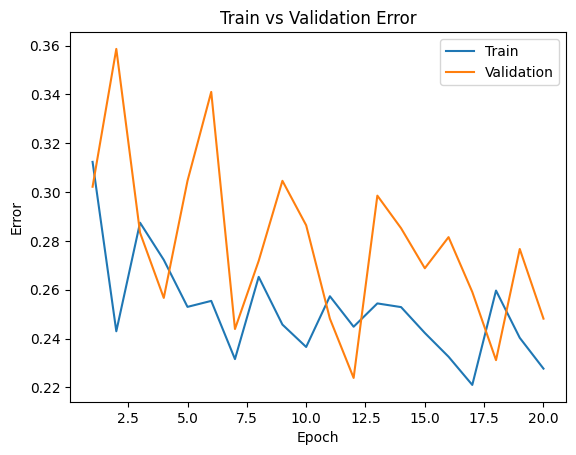

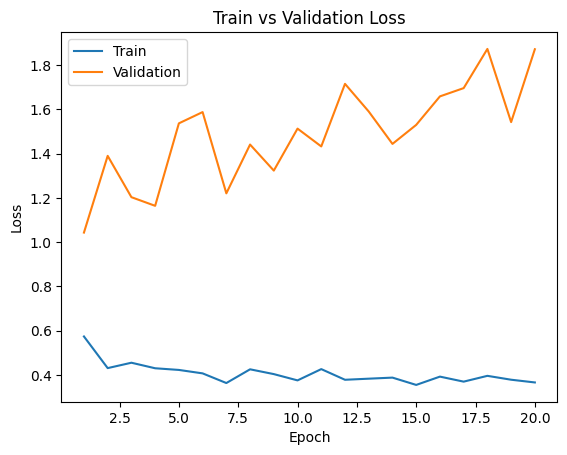

In [ ]:
#Note that we should not use training error
#Note that this is the graph from last iteration of alternate_training
model_path = get_model_name("ResNeSt101", batch_size=64, learning_rate=1e-05, epoch=19)
plot_training_curve(model_path, None)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#Validation Balanced Accuracy
# B0- 0.66
# B1- 0.69
# B2- 0.659
# B3- 0.676
# ResNet18 - 0.667
# SEResNext50- 0.652
# ResNest101- 0.681
# SEResNext101- 0.7

#Loading each model with the highest validation balanced accuracy from all epochs
B0 = EffNetB0()
B0 = B0.to(device)
model_path = "EffNetB0_Swap2"
state = torch.load(model_path)
B0.load_state_dict(state)


B1 = EffNetB1()
B1 = B1.to(device)
model_path = "EffNetB1_Swap2"
state = torch.load(model_path)
B1.load_state_dict(state)

B2 = EffNetB2()
B2 = B2.to(device)
model_path = "EffNetB2_Swap2"
state = torch.load(model_path)
B2.load_state_dict(state)

B3 = EffNetB3()
B3 = B3.to(device)
model_path = "EffNetB3_Swap2"
state = torch.load(model_path)
B3.load_state_dict(state)

RS18 = ResNet18Model()
RS18 = RS18.to(device)
model_path = "ResNet18_Swap2"
state = torch.load(model_path)
RS18.load_state_dict(state)

SE50 = SEResNeXt50()
SE50 = SE50.to(device)
model_path = "SEResNeXt50_Swap2"
state = torch.load(model_path)
SE50.load_state_dict(state)


RS101 = ResNeSt101Model()
RS101 = RS101.to(device)
model_path = "ResNeSt101_Swap2"
state = torch.load(model_path)
RS101.load_state_dict(state)

SE101 = SEResNeXt101Model()
SE101 = SE101.to(device)
model_path = "SEResNeXt101_Swap0"
state = torch.load(model_path)
SE101.load_state_dict(state)


<ipython-input-49-5e5e46e77779>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)
<ipython-input-49-5e5e46e77779>:22: FutureWarning: You are u

<All keys matched successfully>

In [ ]:
class AverageEnsembler(nn.Module):
    def __init__(self, models):
        """
        Initialize the AverageEnsembler with a list of models.
        :param models: List of PyTorch models
        """
        super(AverageEnsembler, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, image, meta):
        """
        Run the forward method on all models and average their predictions.
        """

        predictions = [model(image,meta) for model in self.models]  # Run forward on each model
        ensemble_output = torch.mean(torch.stack(predictions), dim=0)  # Average predictions
        return ensemble_output

In [ ]:
def generate_random_combinations():
    random.seed(76)

    #8 models
    number_set = list(range(8))

    coms = []
    # Generate 10 random combinations
    for i in range(10):
        # Randomly choose the size of the combination (between 1 and 8)
        combo_size = random.randint(1, len(number_set))

        # Generate a random combination of the chosen size
        random_combo = random.sample(number_set, combo_size)

        coms.append(random_combo)
    return coms
coms = generate_random_combinations()
coms

[[7, 3, 1, 2, 0, 5],
 [4, 2, 3, 5],
 [1, 2, 6, 7],
 [0, 7, 5, 3, 4, 2],
 [5, 4, 3, 0],
 [6, 1],
 [3, 5],
 [4, 5],
 [1, 0],
 [3]]

In [ ]:
all_nets = [B0,B1,B2,B3,RS18,SE50,RS101,SE101]
max_bal = float('-inf')
best_com = None
for com in coms:
    nets = [all_nets[i] for i in com]
    ensembler = AverageEnsembler(nets)
    err, loss, f1, sensitivity, bal_acc = evaluateCNN(ensembler, val_loader, nn.CrossEntropyLoss(), include_meta = True, clas_report=False)
    if bal_acc > max_bal:
        max_bal = bal_acc
        best_com = com
        print(f"Current Best Balanced Accuracy: {max_bal}, for combination: {best_com}")
print(f"Maximum balanced Accuracy: {max_bal}, for combination : {best_com}")

Current Best Balanced Accuracy: 0.7081036100116409, for combination: [7, 3, 1, 2, 0, 5]
Current Best Balanced Accuracy: 0.7111458546945036, for combination: [1, 2, 6, 7]
Maximum balanced Accuracy: 0.7111458546945036, for combination : [1, 2, 6, 7]


In [ ]:
ensembler = AverageEnsembler([B1,B2,SE101,RS101])
err, loss, f1, sensitivity, bal_acc = evaluateCNN(ensembler, val_loader, nn.CrossEntropyLoss(), include_meta = True, clas_report=True)
print(f"Validation Accuracy: {1-err}, Validation F1: {f1}, Validation Sensitivity: {sensitivity}, Validation Balanced Accuracy: {bal_acc}")

              precision    recall  f1-score   support

          nv       0.95      0.77      0.85       998
       akiec       0.38      0.64      0.48        70
          df       0.41      0.71      0.52        17
        vasc       0.57      0.81      0.67        21
         bkl       0.61      0.58      0.59       161
         bcc       0.70      0.81      0.75       197
         mel       0.43      0.67      0.52       184

    accuracy                           0.74      1648
   macro avg       0.58      0.71      0.63      1648
weighted avg       0.80      0.74      0.75      1648

Validation Accuracy: 0.7366504854368932, Validation F1: 0.7543890208661412, Validation Sensitivity: 0.7366504854368932, Validation Balanced Accuracy: 0.7111458546945036


In [ ]:
err, loss, f1, sensitivity, bal_acc = evaluateCNN(ensembler, test_loader, nn.CrossEntropyLoss(), include_meta = True, clas_report=True)
print(f"Test Accuracy: {1-err}, Test F1: {f1},\nTest Sensitivity: {sensitivity}, Test Balanced Accuracy: {bal_acc}")

              precision    recall  f1-score   support

          nv       0.97      0.80      0.88       997
       akiec       0.43      0.63      0.51        71
          df       0.41      0.65      0.50        17
        vasc       0.61      0.95      0.75        20
         bkl       0.68      0.66      0.67       162
         bcc       0.74      0.83      0.78       197
         mel       0.44      0.67      0.53       184

    accuracy                           0.77      1648
   macro avg       0.61      0.74      0.66      1648
weighted avg       0.82      0.77      0.79      1648

Test Accuracy: 0.7694174757281553, Test F1: 0.7853396866099427,
Test Sensitivity: 0.7694174757281553, Test Balanced Accuracy: 0.741960750106209


**Model Evaluation**

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 8))

    # Create heatmap using seaborn
    sns.heatmap(cm,
                annot=True,  # Show numbers in each cell
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color palette
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

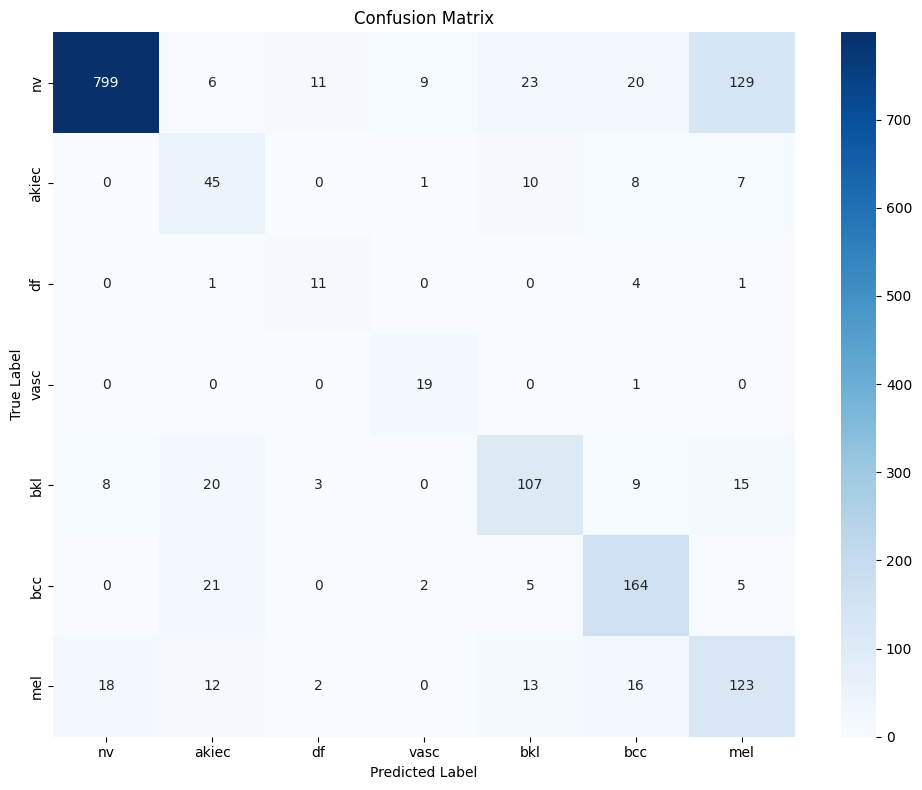

In [ ]:
all_true = []
all_pred = []
with torch.no_grad():
  for i, data in enumerate(test_loader, 0):
      inputs, meta, labels = data
      inputs = inputs.to(device)
      meta = meta.to(device)
      labels = labels.long().to(device)

      outputs = ensembler(inputs, meta)
      predicted = torch.argmax(outputs, dim=1)
      all_true.append(labels)
      all_pred.append(predicted)

#{'nv': 0, 'akiec': 1, 'df': 2, 'vasc': 3, 'bkl':4, 'bcc':5, 'mel':6}
all_true = torch.cat(all_true)
all_pred = torch.cat(all_pred)
plot_confusion_matrix(all_true.to('cpu'), all_pred.to('cpu'), ['nv','akiec','df','vasc','bkl','bcc','mel'])

In [ ]:
misclassified_inputs = []
all_true = []
all_pred = []

with torch.no_grad():
  for i, data in enumerate(test_loader, 0):
      inputs, meta, labels = data
      inputs = inputs.to(device)
      meta = meta.to(device)
      labels = labels.long().to(device)

      outputs = ensembler(inputs, meta)
      predicted = torch.argmax(outputs, dim=1)
      all_true.append(labels)
      all_pred.append(predicted)

      # Check for specific misclassification
      for j in range(len(labels)):
          if labels[j].item() == 0 and predicted[j].item() == 6:
              misclassified_inputs.append(inputs[j])

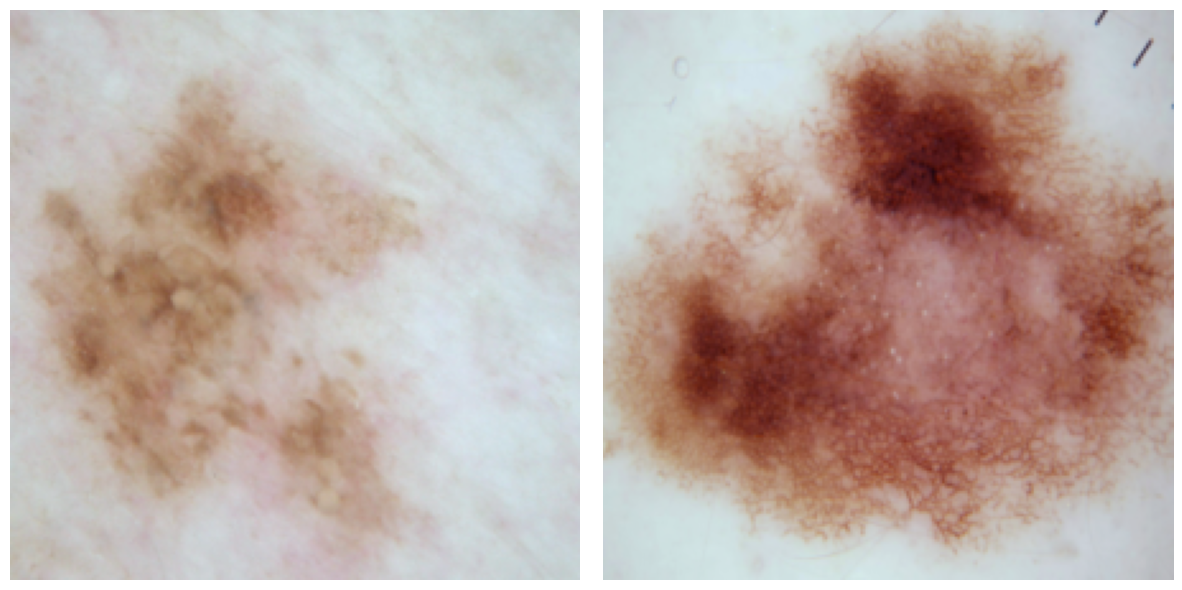

In [ ]:

plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for index, img in enumerate(misclassified_inputs):
    if index == 7 or index == 8:
        image = np.transpose(img.to("cpu"), [1,2,0])
        image = image / 2 + 0.5
        plt.subplot(1, 2, index-6)
        plt.axis('off')
        plt.imshow(image)

    if index == 9:
        break

plt.tight_layout()
plt.show()

In [ ]:
class_pictures = {}
vasc_pictures = []
misclassified_vasc = []
with torch.no_grad():
  for i, data in enumerate(test_loader, 0):
      inputs, meta, labels = data
      inputs = inputs.to(device)
      meta = meta.to(device)
      labels = labels.long().to(device)

      outputs = ensembler(inputs, meta)
      predicted = torch.argmax(outputs, dim=1)
      all_true.append(labels)
      all_pred.append(predicted)

      for j in range(len(labels)):
          if labels[j].item() not in class_pictures:
              class_pictures[labels[j].item()] = inputs[j].to('cpu')
          if labels[j].item() == 3:
              vasc_pictures.append(inputs[j].to('cpu'))
          if labels[j].item() == 3 and predicted[j].item() == 5:
              misclassified_vasc.append(inputs[j].to('cpu'))
print(class_pictures.keys())

dict_keys([0, 6, 5, 1, 4, 3, 2])


In [ ]:
sorted_class_pictures = dict(sorted(class_pictures.items()))
pictures = list(sorted_class_pictures.values())

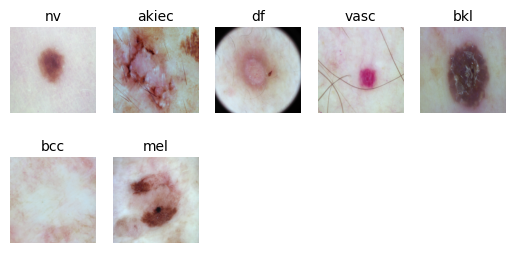

In [ ]:
texts = ['nv','akiec','df','vasc','bkl','bcc','mel']
for index, img in enumerate(pictures):
  image = np.transpose(img, [1,2,0])
  image = image / 2 + 0.5
  plt.subplot(3, 5, index+1)
  plt.axis('off')
  plt.imshow(image)
  plt.title(texts[index], fontsize=10, pad=5)


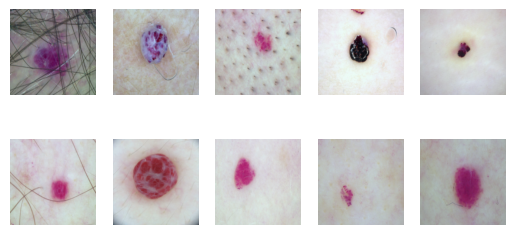

In [ ]:
for index, img in enumerate(vasc_pictures):
    image = np.transpose(img, [1,2,0])
    image = image / 2 + 0.5
    plt.subplot(3, 5, index+1)
    plt.axis('off')
    plt.imshow(image)
    if index == 9:
        break

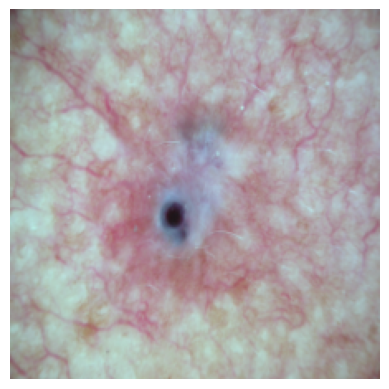

In [ ]:
image = np.transpose(misclassified_vasc[0], [1,2,0])
image = image / 2 + 0.5
plt.axis('off')
plt.imshow(image)

# Baseline Model

In [ ]:
#prepare_data function prepares data for decision tree & logistic regression
def prepare_data(X):
  #Get resized flattened image for each row
  flattened_images = X['image_id'].apply(get_image, args=(False, 24, 18, False))

  #Concatenate the flattened image to our dataframe
  image_features = pd.DataFrame(flattened_images.tolist(), index=X.index)
  X = pd.concat([X.drop(columns=['image_id']), image_features], axis=1)

  #Now we have a dataframe with large amount of columns
  X.columns = X.columns.astype(str)
  return X
formatted_X_train = prepare_data(X_train)
print(formatted_X_train.head())


    age  sex_female  sex_male  localization_anterior torso  \
0  67.5           0         1                            0   
1  72.5           0         1                            0   
2  62.5           0         1                            0   
3  77.5           0         1                            0   
4  72.5           0         1                            0   

   localization_head/neck  localization_lower extremity  \
0                       0                             1   
1                       1                             0   
2                       1                             0   
3                       1                             0   
4                       1                             0   

   localization_oral/genital  localization_palms/soles  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0            

In [ ]:
formatted_X_val = prepare_data(X_val)
formatted_X_test = prepare_data(X_test)

In [ ]:
#Convert label to int for training
mapping = {'nv': 0, 'akiec': 1, 'df': 2, 'vasc': 3, 'bkl':4, 'bcc':5, 'mel':6}
formatted_y_train = y_train.map(mapping)
formatted_y_val = y_val.map(mapping)
formatted_y_test = y_test.map(mapping)


**Logistic Regressions**

In [ ]:
def evaluate(model, X, y):
  y_pred = model.predict(X)
  accuracy = accuracy_score(y,y_pred)
  f1 = f1_score(y,y_pred, average='weighted')
  sensitivity = recall_score(y,y_pred,average='weighted')
  balanced_accuracy = balanced_accuracy_score(y,y_pred)
  return accuracy, f1, sensitivity, balanced_accuracy

In [ ]:
from sklearn import preprocessing
#Standardization on X for Logistic Regression
scaler = preprocessing.StandardScaler().fit(formatted_X_train)
X_scaled_train = scaler.transform(formatted_X_train)
X_scaled_val = scaler.transform(formatted_X_val)
X_scaled_test = scaler.transform(formatted_X_test)

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.001)
model.fit(X_scaled_train, formatted_y_train)

train_accuracy, train_f1, train_sensitivity,train_balanced_acc = evaluate(model, X_scaled_train, formatted_y_train)
val_accuracy, val_f1, val_sensitivity,val_balanced_acc = evaluate(model, X_scaled_val, formatted_y_val)
test_accuracy, test_f1, test_sensitivity,test_balanced_acc = evaluate(model, X_scaled_test, formatted_y_test)


print(f"Train Accuracy: {train_accuracy}, Train F1: {train_f1}, Train Sensitivity: {train_sensitivity}, Train Balanced Accuracy: {train_balanced_acc}")
print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}, Validation Sensitivity: {val_sensitivity}, Validation Balanced Accuracy: {val_balanced_acc}")
print(f"Test Accuracy: {test_accuracy}, Test F1: {test_f1}, Test Sensitivity: {test_sensitivity}, Test Balanced Accuracy: {test_balanced_acc}")

Train Accuracy: 0.694215142525474, Train F1: 0.6863591265987634, Train Sensitivity: 0.694215142525474, Train Balanced Accuracy: 0.7005998448993366
Validation Accuracy: 0.5722087378640777, Validation F1: 0.6151416421150063, Validation Sensitivity: 0.5722087378640777, Validation Balanced Accuracy: 0.47392943899182133
Test Accuracy: 0.5879854368932039, Test F1: 0.6286882990745044, Test Sensitivity: 0.5879854368932039, Test Balanced Accuracy: 0.473333502191299


**Decision Tree**

In [ ]:
model = tree.DecisionTreeClassifier(random_state=0)

param_dist = {
    'max_depth': np.arange(9, 12, 1),
    'min_samples_split': np.arange(3, 8, 1)
}
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=8,
    cv=5,
    random_state=0,
)

random_search.fit(formatted_X_train, formatted_y_train)
model = random_search.best_estimator_


In [ ]:
train_accuracy, train_f1, train_sensitivity,train_balanced_acc = evaluate(model, formatted_X_train, formatted_y_train)
val_accuracy, val_f1, val_sensitivity,val_balanced_acc = evaluate(model, formatted_X_val, formatted_y_val)
test_accuracy, test_f1, test_sensitivity,test_balanced_acc = evaluate(model, formatted_X_test, formatted_y_test)


print(f"Train Accuracy: {train_accuracy}, Train F1: {train_f1}, Train Sensitivity: {train_sensitivity}, Train Balanced Accuracy: {train_balanced_acc}")
print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}, Validation Sensitivity: {val_sensitivity}, Validation Balanced Accuracy: {val_balanced_acc}")
print(f"Test Accuracy: {test_accuracy}, Test F1: {test_f1}, Test Sensitivity: {test_sensitivity}, Test Balanced Accuracy: {test_balanced_acc}")

Train Accuracy: 0.8503160067070812, Train F1: 0.848838753480128, Train Sensitivity: 0.8503160067070812, Train Balanced Accuracy: 0.8534320127789271
Validation Accuracy: 0.5321601941747572, Validation F1: 0.5632338835379672, Validation Sensitivity: 0.5321601941747572, Validation Balanced Accuracy: 0.29098979146955645
Test Accuracy: 0.5558252427184466, Test F1: 0.5888675872771401, Test Sensitivity: 0.5558252427184466, Test Balanced Accuracy: 0.34030255275833887


We have tried combinations of hyperparameters, and came to a conclusion that:

1. A Single Decision Tree overfits the data very easily considering the high number of features compared to the size of datas
2. Reducing complexity of the model might solve overfitting; but, the model also loses the ability to capture patterns of our datas which are very comples

Thus, A Single Decision Tree is not able to achieve good performance.